In [1]:
!rm -rf ./utils
!git clone https://github.com/emiliodelgadouy/utils.git --quiet
!pip install comet_ml --quiet
!pip install optuna --quiet
!pip install -q git+https://github.com/tensorflow/addons.git
!pip install --no-cache-dir -U crcmod --quiet > /dev/null 2>&1
print("✅ Dependencies installed!")
from comet_ml import Experiment
from tensorflow.keras import mixed_precision
import optuna
import numpy as np
import tensorflow as tf
import keras
from utils.Dataset import Dataset
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.inception_v3 import preprocess_input
from google.colab import auth
import tensorflow as tf
import tensorflow_addons as tfa
import numpy as np

print("✅ Imports ready!")


auth.authenticate_user()
!gsutil cp gs://helen-data/dumps/images_original.tar.xz ./
!tar -xvf images_original.tar.xz -C ./utils > /dev/null 2>&1
print("✅ Data downloaded!")
gpus = tf.config.list_physical_devices('GPU')
mixed_precision.set_global_policy("mixed_float16")
AUTOTUNE = tf.data.AUTOTUNE
print("✅ Env ready!")
print("✅ GPU avilable" if tf.config.list_physical_devices("GPU") else "❌ NO GPU avilable")
print(AUTOTUNE)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 743.7/743.7 kB 57.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 79.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 39.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.4/247.4 kB 29.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.7/89.7 kB 147.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
✅ Dependencies installed!
✅ Imports ready!
Copying gs://helen-data/dumps/images_original.tar.xz...
\ [1 files][  2.6 GiB/  2.6 GiB]   41.2 MiB/s                                   
Operation completed over 1 objects/2.6 GiB.                                      
✅ Data downloaded!
✅ Env ready!
✅ GPU avilable
-1


In [13]:
import tensorflow_addons as tfa


/usr/local/lib/python3.12/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
/usr/local/lib/python3.12/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.13.0 and strictly below 2.16.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.19.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're u

In [11]:
dataset = Dataset(lateralize_images=True, dataset_csv="./ds_balanced.csv")
full_train = dataset[(dataset["split"] == "training")]
ds_test = dataset[(dataset["split"] == "test")]
ds_train, ds_val = train_test_split(
    full_train,
    test_size=0.20,
    random_state=42,
    stratify=full_train["findings"]
)

IMG_SIZE = (299, 299)
BATCH_SIZE = 128
EPOCHS = 200

labels_train_np = ds_train["findings"].astype("int64").to_numpy()
classes = np.unique(labels_train_np)
weights = class_weight.compute_class_weight('balanced', classes=classes, y=labels_train_np)
cw = {int(c): float(w) for c, w in zip(classes, weights)}

keys = tf.constant(list(cw.keys()), dtype=tf.int64)
vals = tf.constant(list(cw.values()), dtype=tf.float32)

class_weight_table = tf.lookup.StaticHashTable(
    initializer=tf.lookup.KeyValueTensorInitializer(keys, vals),
    default_value=tf.constant(1.0, tf.float32)
)



In [14]:

def _augment(img):
    # Rotación aleatoria (±10°)
    angle = tf.random.uniform([], -10, 10) * np.pi / 180.0
    img = tfa.image.rotate(img, angle, interpolation='BILINEAR')

    # Zoom aleatorio (crop + resize)
    zoom_scale = tf.random.uniform([], 0.9, 1.1)  # 90%–110%
    h = tf.shape(img)[0]; w = tf.shape(img)[1]
    new_h = tf.cast(tf.cast(h, tf.float32) * zoom_scale, tf.int32)
    new_w = tf.cast(tf.cast(w, tf.float32) * zoom_scale, tf.int32)
    img = tf.image.resize(img, (new_h, new_w))
    img = tf.image.resize_with_crop_or_pad(img, h, w)

    # Brillo / contraste
    img = tf.image.random_brightness(img, max_delta=0.1)
    img = tf.image.random_contrast(img, lower=0.9, upper=1.1)

    # Clampeo a [0,1] para que las aug trabajen con intensidades válidas
    img = tf.clip_by_value(img, 0.0, 1.0)
    return img

def _preprocess_and_weight(img, label):
    y = tf.cast(label, tf.float32)
    y_int = tf.cast(label, tf.int64)
    sw = class_weight_table.lookup(y_int)
    return img, y, sw


def _safe_float_col(df, name):
    if name in df.columns:
        return df[name].astype("float32").to_numpy()
    return np.full((len(df),), np.nan, dtype="float32")

def _build_slices(df):
    paths = df["path"].astype(str).to_numpy()
    labels = df["findings"].astype("float32").to_numpy()
    laterality  = df["laterality"].astype(str).to_numpy() if "laterality" in df.columns else np.array([""] * len(df))
    xmin = _safe_float_col(df, "xmin")
    ymin = _safe_float_col(df, "ymin")
    xmax = _safe_float_col(df, "xmax")
    ymax = _safe_float_col(df, "ymax")
    return paths, labels, laterality, xmin, ymin, xmax, ymax

def _center_crop(img, target_hw):
    th, tw = target_hw[0], target_hw[1]
    h = tf.shape(img)[0]; w = tf.shape(img)[1]
    tf.debugging.assert_greater_equal(h, th, message="Imagen demasiado chica en altura para crop")
    tf.debugging.assert_greater_equal(w, tw, message="Imagen demasiado chica en ancho para crop")
    y0 = tf.maximum(0, (h - th) // 2); x0 = tf.maximum(0, (w - tw) // 2)
    y0 = tf.minimum(y0, h - th); x0 = tf.minimum(x0, w - tw)
    return tf.image.crop_to_bounding_box(img, y0, x0, th, tw)

def _center_crop_on_point(img, cx, cy, target_hw):
    th, tw = target_hw[0], target_hw[1]
    h = tf.shape(img)[0]; w = tf.shape(img)[1]
    tf.debugging.assert_greater_equal(h, th, message="Imagen demasiado chica en altura para crop")
    tf.debugging.assert_greater_equal(w, tw, message="Imagen demasiado chica en ancho para crop")
    y0 = tf.cast(tf.round(cy - tf.cast(th, tf.float32) / 2.0), tf.int32)
    x0 = tf.cast(tf.round(cx - tf.cast(tw, tf.float32) / 2.0), tf.int32)
    y0 = tf.clip_by_value(y0, 0, h - th); x0 = tf.clip_by_value(x0, 0, w - tw)
    return tf.image.crop_to_bounding_box(img, y0, x0, th, tw)

def _maybe_flip_left_right(img, lat_str):
    lat = tf.strings.upper(lat_str)
    is_right = tf.strings.regex_full_match(lat, r"(R(IGHT)?)|(.*-R$)|(^R-.*)")
    return is_right, tf.cond(is_right, lambda: tf.image.flip_left_right(img), lambda: img)

def _flip_roi_if_needed(is_right, img, xmin, ymin, xmax, ymax):
    w = tf.shape(img)[1]
    def _flip():
        x_min2 = tf.cast(w - 1, tf.float32) - xmax
        x_max2 = tf.cast(w - 1, tf.float32) - xmin
        return x_min2, ymin, x_max2, ymax
    def _same():
        return xmin, ymin, xmax, ymax
    return tf.cond(is_right, _flip, _same)

def _roi_valid(xmin, ymin, xmax, ymax):
    return (
        tf.math.is_finite(xmin) & tf.math.is_finite(ymin) &
        tf.math.is_finite(xmax) & tf.math.is_finite(ymax) &
        (xmax > xmin) & (ymax > ymin)
    )

def _draw_bb(img, xmin, ymin, xmax, ymax):
    h = tf.shape(img)[0]; w = tf.shape(img)[1]
    ymin_n = ymin / tf.cast(h, tf.float32)
    xmin_n = xmin / tf.cast(w, tf.float32)
    ymax_n = ymax / tf.cast(h, tf.float32)
    xmax_n = xmax / tf.cast(w, tf.float32)
    boxes = tf.stack([ymin_n, xmin_n, ymax_n, xmax_n])[tf.newaxis, tf.newaxis, :]
    return tf.image.draw_bounding_boxes(img[tf.newaxis], boxes, colors=[[1.0, 0.0, 0.0]])[0]


def _load_roi(path, label, lat, xmin, ymin, xmax, ymax):
    bytes_ = tf.io.read_file(path)
    img = tf.io.decode_image(bytes_, channels=3, expand_animations=False)
    img = tf.image.convert_image_dtype(img, tf.float32)  # [0,1]
    is_right, img = _maybe_flip_left_right(img, lat)
    # xmin, ymin, xmax, ymax = _flip_roi_if_needed(is_right, img, xmin, ymin, xmax, ymax)

    return img, label, xmin, ymin, xmax, ymax

def _train_map_roi(img, label, xmin, ymin, xmax, ymax):
    target = tf.constant(IMG_SIZE, tf.int32)  # (H, W)
    th, tw = target[0], target[1]

    pos = tf.equal(tf.cast(label, tf.int32), 1)
    valid = _roi_valid(xmin, ymin, xmax, ymax)

    def _pos_branch():
        h = tf.shape(img)[0]; w = tf.shape(img)[1]

        # Centro ROI (o centro imagen si ROI inválido)
        cx = tf.where(valid, (xmin + xmax) / 2.0, tf.cast(w, tf.float32) / 2.0)
        cy = tf.where(valid, (ymin + ymax) / 2.0, tf.cast(h, tf.float32) / 2.0)

        # Jitter relativo al tamaño del ROI (±40%)
        roi_w = tf.where(valid, xmax - xmin, tf.cast(w, tf.float32))
        roi_h = tf.where(valid, ymax - ymin, tf.cast(h, tf.float32))
        jitter_x = tf.random.uniform([], -0.4, 0.4, dtype=tf.float32) * roi_w
        jitter_y = tf.random.uniform([], -0.4, 0.4, dtype=tf.float32) * roi_h
        cx_jit = cx + jitter_x; cy_jit = cy + jitter_y

        # BB solo en positivos
        # img_bb = tf.cond(
        #     valid,
        #     lambda: _draw_bb(img, xmin, ymin, xmax, ymax),
        #     lambda: img
        # )

        out = _center_crop_on_point(img, cx_jit, cy_jit, target)
        return tf.ensure_shape(out, (IMG_SIZE[0], IMG_SIZE[1], 3))

    def _neg_branch():
        h = tf.shape(img)[0]; w = tf.shape(img)[1]
        tf.debugging.assert_greater_equal(h, th, message="Imagen demasiado chica en altura para random crop")
        tf.debugging.assert_greater_equal(w, tw, message="Imagen demasiado chica en ancho para random crop")
        y0 = tf.random.uniform((), 0, h - th + 1, dtype=tf.int32)
        x0 = tf.random.uniform((), 0, w - tw + 1, dtype=tf.int32)
        out = tf.image.crop_to_bounding_box(img, y0, x0, th, tw)
        return tf.ensure_shape(out, (IMG_SIZE[0], IMG_SIZE[1], 3))

    img2 = tf.cond(pos, _pos_branch, _neg_branch)
    return img2, label

def _eval_map_roi(img, label, xmin, ymin, xmax, ymax):
    target = tf.constant(IMG_SIZE, tf.int32)
    pos = tf.equal(tf.cast(label, tf.int32), 1)
    valid = _roi_valid(xmin, ymin, xmax, ymax)

    def _pos():
        h = tf.shape(img)[0]; w = tf.shape(img)[1]
        cx = tf.where(valid, (xmin + xmax) / 2.0, tf.cast(w, tf.float32) / 2.0)
        cy = tf.where(valid, (ymin + ymax) / 2.0, tf.cast(h, tf.float32) / 2.0)
        out = _center_crop_on_point(img, cx, cy, target)
        return tf.ensure_shape(out, (IMG_SIZE[0], IMG_SIZE[1], 3))

    def _neg():
        return _center_crop(img, target)

    img2 = tf.cond(pos, _pos, _neg)
    return img2, label


# ==== DATASET BUILDER ====
def make_ds(df, training: bool, shuffle=False):
    paths, labels, later, xmin, ymin, xmax, ymax = _build_slices(df)

    ds = tf.data.Dataset.from_tensor_slices((paths, labels, later, xmin, ymin, xmax, ymax))
    if shuffle:
        ds = ds.shuffle(min(8192, len(df)), reshuffle_each_iteration=True)

    ds = ds.map(_load_roi, num_parallel_calls=AUTOTUNE)
    ds = ds.map(_train_map_roi if training else _eval_map_roi, num_parallel_calls=AUTOTUNE)

    if training: #Augmentacion solo para training
        ds = ds.map(lambda img, lbl: (_augment(img), lbl), num_parallel_calls=AUTOTUNE)

    ds = ds.map(_preprocess_and_weight, num_parallel_calls=AUTOTUNE)
    ds = ds.batch(BATCH_SIZE, drop_remainder=False).prefetch(AUTOTUNE)

    opts = tf.data.Options()
    opts.experimental_deterministic = False
    return ds.with_options(opts)


# ==== EJEMPLO DE USO ====
train_ds = make_ds(ds_train, training=True,  shuffle=True)
val_ds   = make_ds(ds_val,   training=False, shuffle=False)
test_ds  = make_ds(ds_test,  training=False, shuffle=False)


In [ ]:
# val_ds   = make_ds(ds_val,   training=False)
# test_ds  = make_ds(ds_test,  training=False)

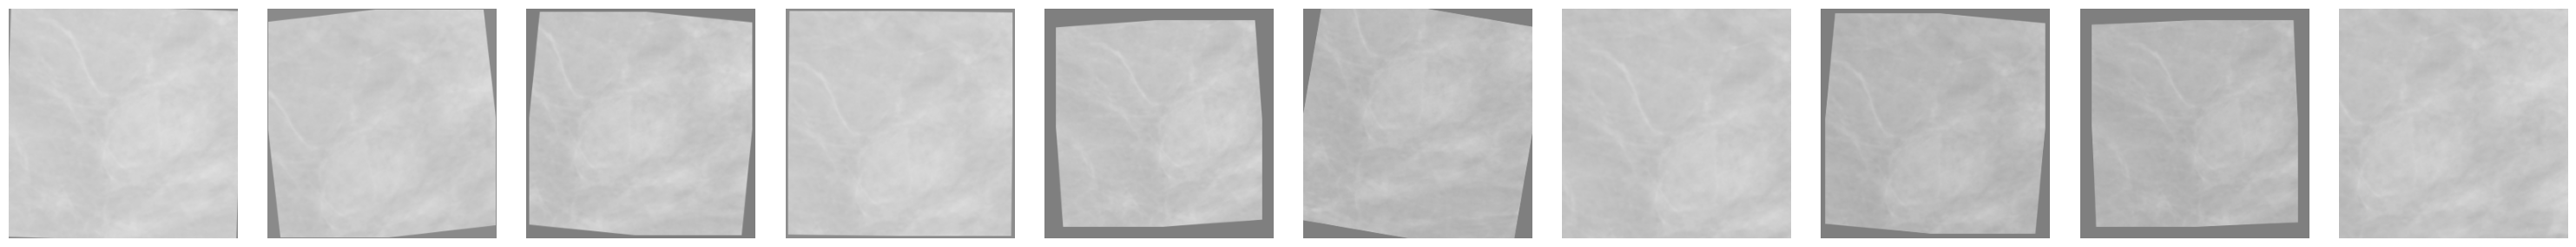

In [15]:
import matplotlib.pyplot as plt
import tensorflow as tf

# Dataset fijo con 10 imágenes positivas
explore_ds = make_ds(
    ds_train[ds_train["findings"] == 1].head(1),
    training=True,
    shuffle=False
)

N_AUGS = 10  # cuántas veces muestro cada imagen

# Convertimos el dataset a lista para poder iterar de forma estable
explore_list = list(explore_ds.unbatch().as_numpy_iterator())

# Crear figura: 10 filas (imágenes) × N_AUGS columnas (augmentations)
fig, axes = plt.subplots(len(explore_list), N_AUGS, figsize=(3 * N_AUGS, 3 * len(explore_list)))

for i, (img, lbl, _) in enumerate(explore_list):
    for j in range(N_AUGS):
        # Para obtener un augment distinto, volvemos a pasar el mismo path
        # recreando un dataset con UN solo elemento
        one_df = ds_train[ds_train["findings"] == 1].iloc[[i]]
        one_ds = make_ds(one_df, training=True, shuffle=False)

        aug_img, aug_lbl, _ = next(iter(one_ds))
        aug_img = (aug_img[0].numpy() + 1) / 2.0

        ax = axes[i, j] if len(explore_list) > 1 else axes[j]
        ax.imshow(aug_img)
        ax.axis("off")
        if j == 0:
            ax.set_ylabel(f"Img {i} (Label={lbl:.0f})", fontsize=10)

plt.tight_layout()
plt.show()


In [16]:
import os, gc, time, random
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.layers import GlobalMaxPooling2D, Dense, BatchNormalization, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC

# tensorboard_callback = tf.keras.callbacks.TensorBoard( log_dir="./logs/fit", histogram_freq=1, profile_batch='1,5' )

def build_model(l2_reg, dropout_rate, unfreeze_pct):
    base = InceptionV3(weights='imagenet', include_top=False, input_shape=(*IMG_SIZE, 3))
    for l in base.layers:
        l.trainable = False
    n_total = len(base.layers)
    n_unfreeze = int(n_total * unfreeze_pct)
    if n_unfreeze > 0:
        for l in base.layers[-n_unfreeze:]:
            l.trainable = True

    x = base.output
    x = GlobalMaxPooling2D()(x)
    x = Dense(512, activation='relu',
              kernel_regularizer=tf.keras.regularizers.l1_l2(l1=1e-4, l2=l2_reg))(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)
    out = Dense(1, activation='sigmoid', dtype='float32')(x)
    return Model(inputs=base.input, outputs=out)
def objective(trial):
    experiment = Experiment(
        api_key="W8IluWhLfvXgLr8ggg1bwZKTf",
        project_name="analisis",
        workspace="emiliodelgadouy",
        auto_output_logging="simple",
        log_code=False
    )
    experiment.set_name(f"TF_{trial.number}")

    # seeds
    random.seed(42); np.random.seed(42); tf.random.set_seed(42)

    # Optuna Hiperparameters Search
    lr          = trial.suggest_float('learning_rate', 1e-5, 1e-3, log=True)
    dropout     = trial.suggest_float('dropout_rate', 0.2, 0.6)
    l2_reg      = trial.suggest_float('l2_reg', 1e-6, 1e-3, log=True)
    unfreeze_pc = trial.suggest_float("unfreeze_pct", 0.0, 0.3)

    experiment.log_parameters({
        "learning_rate": lr,
        "dropout_rate": dropout,
        "l2_reg": l2_reg,
        "backbone": "InceptionV3",
        "batch_size": BATCH_SIZE,
        "img_size": IMG_SIZE,
        "epochs": EPOCHS,
        "unfreeze_pct": unfreeze_pc
    })

    model = build_model(l2_reg, dropout, unfreeze_pc)
    model.compile(optimizer=Adam(learning_rate=lr),
                  loss='binary_crossentropy',
                  metrics=['accuracy', AUC(name='auc_roc', curve='ROC')])

    t0 = time.time()
    model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=EPOCHS,
        # callbacks=[tensorboard_callback],
        verbose=1
    )
    elapsed = time.time() - t0

    # Evaluo modelo
    loss, acc, auc = model.evaluate(test_ds, verbose=1)

    experiment.log_metric("final_test_loss", loss)
    experiment.log_metric("final_test_accuracy", acc)
    experiment.log_metric("final_test_auc_roc", auc)

    experiment.end()


    # Libero memoria
    del model
    tf.keras.backend.clear_session()
    gc.collect()

    # Voy a maximizar accuracy
    return float(acc)

In [ ]:
    study = optuna.create_study(
        direction="maximize",
        study_name="inceptionv3_tuning"
    )
    study.optimize(objective, n_trials=5)

    print("Mejores hiperparámetros encontrados:")
    print(study.best_trial.params)
    print("Mejor accuracy:", study.best_trial.value)

[I 2025-09-01 02:03:54,326] A new study created in memory with name: inceptionv3_tuning
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/emiliodelgadouy/analisis/96ea13863d014d91ab1489370ecc7c62

COMET INFO: Couldn't find a Git repository in '/content' nor in any parent directory. Set `COMET_GIT_DIRECTORY` if your Git Repository is elsewhere.


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


COMET WARNING: tensorflow datasets are not currently supported for gradient and activation auto-logging
COMET INFO: Ignoring automatic log_parameter('verbose') because 'keras:verbose' is in COMET_LOGGING_PARAMETERS_IGNORE


Epoch 1/200
36/36 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.5523 - auc_roc: 0.6414 - loss: 3.3319 - val_accuracy: 0.5661 - val_auc_roc: 0.7658 - val_loss: 3.1412
Epoch 2/200
36/36 ━━━━━━━━━━━━━━━━━━━━ 17s 454ms/step - accuracy: 0.6319 - auc_roc: 0.7678 - loss: 3.1486 - val_accuracy: 0.3765 - val_auc_roc: 0.7880 - val_loss: 3.2915
Epoch 3/200
36/36 ━━━━━━━━━━━━━━━━━━━━ 17s 454ms/step - accuracy: 0.6604 - auc_roc: 0.7919 - loss: 3.0987 - val_accuracy: 0.3862 - val_auc_roc: 0.8008 - val_loss: 3.2859
Epoch 4/200
36/36 ━━━━━━━━━━━━━━━━━━━━ 17s 455ms/step - accuracy: 0.6704 - auc_roc: 0.8018 - loss: 3.0663 - val_accuracy: 0.4312 - val_auc_roc: 0.7907 - val_loss: 3.2441
Epoch 5/200
36/36 ━━━━━━━━━━━━━━━━━━━━ 17s 454ms/step - accuracy: 0.6785 - auc_roc: 0.8044 - loss: 3.0352 - val_accuracy: 0.6508 - val_auc_roc: 0.8213 - val_loss: 3.0212
Epoch 6/200
36/36 ━━━━━━━━━━━━━━━━━━━━ 17s 454ms/step - accuracy: 0.7025 - auc_roc: 0.8253 - loss: 2.9842 - val_accuracy: 0.5071 - val_auc_roc: 0.8345 - 